In [1]:
from google.cloud import bigquery
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import torch.nn.functional as F
import torch_geometric.transforms as T
from torch_geometric.loader import LinkNeighborLoader
from torch_geometric.nn import GraphSAGE
from torch_geometric.data import Data
import time
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.cluster import KMeans

# 0. Objective  

##### Embeddings for news sites are learned using the contents they published. Specifically, news sites, news articles and entities mentioned in the articles are represented as nodes in a graph, and they are connected by edges. Graph Neural Network is used to learn embeddings for the nodes.

# 1. Dataset
## 1.1 GDELT Global Entity Graph (GEG)
GDELT 2.0 is one of the largest platforms for monitoring global world news. 

GDELT Global Entity Graph (GEG) is a dataset of billions of metadata entity annotations from a random sample of hundreds of millions of  worldwide online news articles. All of it updated every minute, annotated using Google’s Cloud Natural Language API. It provides the unique Google-assigned ID for entities for which Google has assigned an identifier (typically only for well-known entities and accompanied by a wikipediaUrl entry)  
https://blog.gdeltproject.org/announcing-the-global-entity-graph-geg-and-a-new-11-billion-entity-dataset/  

A week of data (10/15/2023 - 10/21/2023) is used for this project.

## 1.2 Data pre-processing in Google Cloud BigQuery
- The GEG dataset is available from this public BiqQuery table: gdelt-bq.gdeltv2.geg_gcnlapi
- Create hosts table, articles table and entities table in BigQuery using SQL
- Create 2 edge index tables: host to article and article to entity, also using SQL
- Dbt is used to manage the data pipelines - data is always consistantly reproducible.



<div>
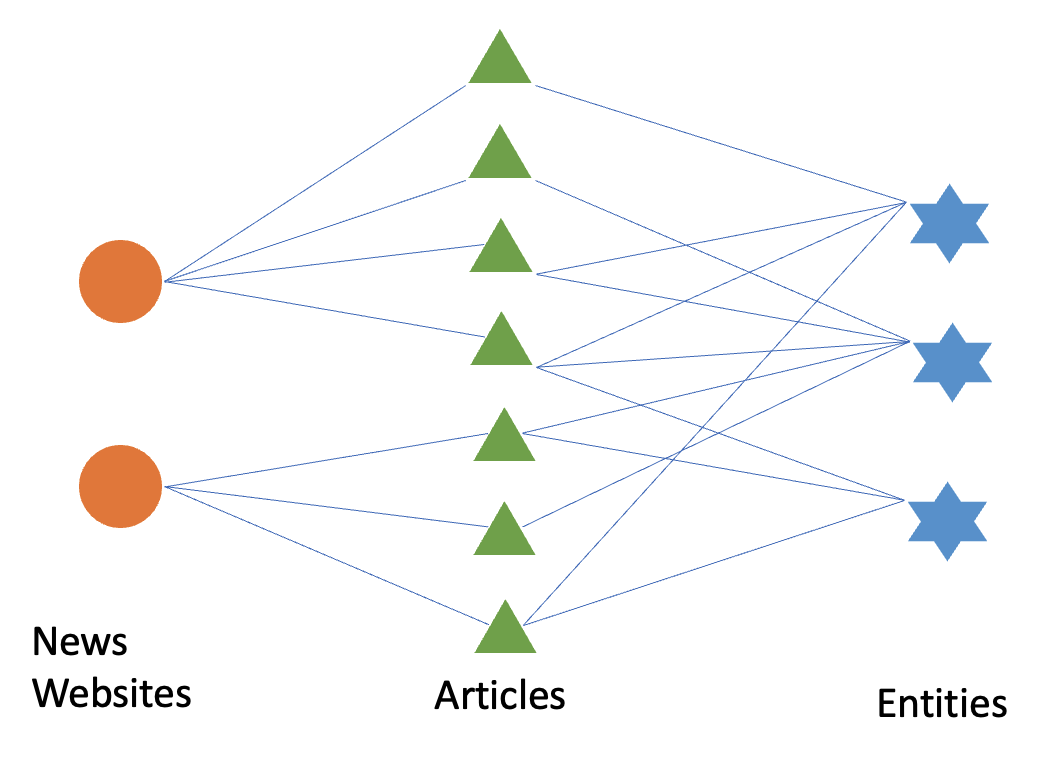
</div>

# 2. Method  

- A graph is used to represent the data:
   - News sites (referred as "hosts" below), articles, and entities are nodes
   - Edges: hosts publish articles, and articles mention entities
- Graph Neural Network (GraphSAGE) is used to learn embeddings for the nodes.
- PyTorch and PyG are used.
- Cluster worlds top news websites using the embeddings.

# 3. Read pre-processed data from BigQuery into Dataframes

In [2]:
# BigQuery api client
bq = bigquery.Client(location="US")


In [3]:
# Get nodes tables from Google Cloud BigQuery
def nodes_tables_from_bq(bq):
    host_query = """  
        SELECT * 
        FROM `gannett-datarevenue.zz_test_pang.hosts_table` 
        """
    article_query = """  
        SELECT * 
        FROM `gannett-datarevenue.zz_test_pang.articles_table` 
        """
    entity_query = """  
        SELECT * 
        FROM `gannett-datarevenue.zz_test_pang.entities_table` 
        """
    query_job = bq.query(host_query, location="US") 
    hosts = query_job.to_dataframe() 
    query_job = bq.query(article_query, location="US") 
    articles = query_job.to_dataframe() 
    query_job = bq.query(entity_query, location="US") 
    entities = query_job.to_dataframe() 
    return hosts, articles, entities

# use local csv files when possible 
def load_nodes_tables(bq):
    exists_hosts = os.path.isfile('data/hosts_table.csv')
    exists_articles = os.path.isfile('data/articles_table.csv')
    exists_entities = os.path.isfile('data/entities_table.csv')
    if exists_hosts and exists_articles and exists_entities:
        print("Read from local csv files.")
        hosts = pd.read_csv('data/hosts_table.csv')
        articles = pd.read_csv('data/articles_table.csv')
        entities = pd.read_csv('data/entities_table.csv')
    else:
        print("Read from BigQuery.")
        hosts, articles, entities = nodes_tables_from_bq(bq)
        hosts.to_csv('data/hosts_table.csv')
        articles.to_csv('data/articles_table.csv')
        entities.to_csv('data/entities_table.csv')
    
    return hosts, articles, entities

In [4]:
# load nodes tables into dataframes
hosts_table, articles_table, entities_table = load_nodes_tables(bq=None)

# sort the dataframes by node ids, this is not necessary but makes a niceer view of the df
hosts_table = hosts_table.sort_values(by=['host_node_id'], ascending=True).reset_index(drop=True)
hosts_table.drop('Unnamed: 0', axis=1, inplace=True)
articles_table = articles_table.sort_values(by=['article_node_id'], ascending=True).reset_index(drop=True)
articles_table.drop('Unnamed: 0', axis=1, inplace=True)
entities_table = entities_table.sort_values(by=['entity_node_id'], ascending=True).reset_index(drop=True)
entities_table.drop('Unnamed: 0', axis=1, inplace=True)

print(hosts_table.shape, articles_table.shape, entities_table.shape)

# Display the first 3 rows
display(hosts_table.head(3))
display(articles_table.head(3))
display(entities_table.head(3))


Read from local csv files.
(20033, 2) (1048852, 6) (1289112, 3)


,host_node_id,host
0,0,www.berchtesgadener-anzeiger.de
1,1,www.toponline.ch
2,2,news.yahoo.com


,article_node_id,host,url,lang,magnitude,score
0,0,www.workersliberty.org,https://www.workersliberty.org/index.php/audio,en,15.9,0.0
1,1,www.wkyc.com,https://www.wkyc.com/article/news/nation-world...,en,24.6,-0.4
2,2,townhall.com,https://townhall.com/tipsheet/mattvespa/2023/1...,en,13.2,-0.4


,entity_node_id,mid,type
0,0,/m/0138vk,LOCATION
1,1,/m/02phmc9,LOCATION
2,2,/m/04gsnk1,ORGANIZATION


## 3.1 Nodes
Nodes Features:
1. Hosts (News Outlets) - News Outlet (identified by host) - use random node feature for host, because hosts do not have rich features
2. Articles (identified by url) - lang, magnitude, score
3. Entity (identified by mid) - type

dim of node features = 12


In [5]:
# node feature dim
node_feature_dim = 12

# use random node feature for host, because hosts do not have rich features
host_features = torch.randn(hosts_table.shape[0], node_feature_dim)  # Random features for each node
host_features.shape

torch.Size([20033, 12])

In [6]:
# features for article: lang, magnitude, score
unique_langs, article_langs = np.unique(articles_table['lang'].values, return_inverse=True)
article_features = pd.get_dummies(article_langs)
article_features['magniture'] = articles_table['magnitude']
article_features['score'] = articles_table['score']
article_features = torch.from_numpy(article_features.values).to(torch.float)
article_features.shape

torch.Size([1048852, 12])

In [7]:
# features for entities: type
unique_types, entity_types = np.unique(entities_table['type'].values, return_inverse=True)
entity_features = pd.get_dummies(entity_types)
entity_features['padding1'], entity_features['padding2'], entity_features['padding3'], entity_features['padding4'], entity_features['padding5'] = [0, 0, 0, 0, 0]
entity_features = torch.from_numpy(entity_features.values).to(torch.float)
entity_features.shape

torch.Size([1289112, 12])

In [8]:
# Nodes combined
combined_nodes_features = torch.cat((host_features, article_features, entity_features), dim=0)
combined_nodes_features.shape

torch.Size([2357997, 12])

## 3.2 Edge Indices
Two types of edges: 
1. host publishes articles
2. article mentions entities


In [9]:
def edge_indices_from_bq(bq):
    host_article_query = """  
        SELECT * 
        FROM `gannett-datarevenue.zz_test_pang.edge_index_host_to_article` 
        """
    article_entity_query = """  
        SELECT * 
        FROM `gannett-datarevenue.zz_test_pang.edge_index_article_to_entity` 
        """
    query_job = bq.query(host_article_query, location="US") 
    host_article = query_job.to_dataframe() 
    query_job = bq.query(article_entity_query, location="US") 
    article_entity = query_job.to_dataframe() 

    return host_article, article_entity

# use local csv files when possible 
def load_edge_indices(bq):
    exists_host_article = os.path.isfile('data/edge_index_host_to_article.csv')
    exists_article_entity = os.path.isfile('data/edge_index_article_to_entity.csv')

    if exists_host_article and exists_article_entity:
        print("Read from local csv files.")
        host_article = pd.read_csv('data/edge_index_host_to_article.csv')
        article_entity = pd.read_csv('data/edge_index_article_to_entity.csv')
    else:
        print("Read from BigQuery.")
        host_article, article_entity = edge_indices_from_bq(bq)
        host_article.to_csv('data/edge_index_host_to_article.csv')
        article_entity.to_csv('data/edge_index_article_to_entity.csv')
    
    return host_article, article_entity
    

In [10]:
# Assign global node ids and combine the 2 edge index tables
# This is necessary because PyG LinkNeighborLoader does not yet support graphs with multiple edge types.

# load edge indices into dataframes
host_article, article_entity = load_edge_indices(bq=None)
print(host_article.shape, article_entity.shape)

# Assign global node ids to nodes
article_node_id_offset = hosts_table.shape[0]
entity_node_id_offset = hosts_table.shape[0] + articles_table.shape[0]

host_article['src'] = host_article['host_node_id']
host_article['trg'] = host_article['article_node_id'] + article_node_id_offset
host_article = host_article.drop(columns=['host_node_id', 'article_node_id'])

article_entity['src'] = article_entity['article_node_id'] + article_node_id_offset
article_entity['trg'] = article_entity['entity_node_id'] + entity_node_id_offset
article_entity = article_entity.drop(columns=['entity_node_id', 'article_node_id'])

# Combine the edges
combined_edges = pd.concat([host_article, article_entity])
print(combined_edges.shape)
assert max(combined_edges['trg'].values) == hosts_table.shape[0] + articles_table.shape[0] + entities_table.shape[0] - 1


Read from local csv files.
(1048852, 2) (39171153, 2)
(40220005, 2)


In [11]:
# construct `edge_index` in COO format

src = torch.from_numpy(combined_edges['src'].values)
trg = torch.from_numpy(combined_edges['trg'].values)
edge_index = torch.stack([src, trg], dim=0)
print(edge_index.shape)
assert edge_index.size() == (2, host_article.shape[0] + article_entity.shape[0])


torch.Size([2, 40220005])


# 4. GraphSAGE 

In [12]:
data = Data(x=combined_nodes_features, edge_index=edge_index)
data

Data(x=[2357997, 12], edge_index=[2, 40220005])

In [13]:
# for mini batch training
train_loader = LinkNeighborLoader(
    data,
    batch_size=4096000,
    shuffle=True,
    neg_sampling_ratio=1.0,
    num_neighbors=[10, 10],
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
data = data.to(device, 'x', 'edge_index')

model = GraphSAGE(
    data.num_node_features,
    hidden_channels=64,
    num_layers=2,
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

cuda


In [14]:
def train():
    model.train()

    total_loss = 0
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        h = model(batch.x, batch.edge_index)
        h_src = h[batch.edge_label_index[0]]
        h_dst = h[batch.edge_label_index[1]]
        pred = (h_src * h_dst).sum(dim=-1)
        loss = F.binary_cross_entropy_with_logits(pred, batch.edge_label)
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * pred.size(0)

    return total_loss / data.num_nodes

# Save a trained model
def save_model(model, path):
    torch.save(model.state_dict(), path)

# Load a model
def load_model(model, path):
    model.load_state_dict(torch.load(path))

In [15]:
# Training loop
times = []
for epoch in range(1, 11):
    start = time.time()
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, ')
    times.append(time.time() - start)
print(f"Median time per epoch: {torch.tensor(times).median():.4f}s")

# Save the trained model
save_model(model, 'news_outlets_model.pt')

Epoch: 001, Loss: 597.6067, 
Epoch: 002, Loss: 109.8725, 
Epoch: 003, Loss: 43.1322, 
Epoch: 004, Loss: 30.2071, 
Epoch: 005, Loss: 24.9959, 
Epoch: 006, Loss: 23.7709, 
Epoch: 007, Loss: 23.0694, 
Epoch: 008, Loss: 22.8539, 
Epoch: 009, Loss: 22.6780, 
Epoch: 010, Loss: 22.5617, 
Median time per epoch: 32.3451s


# 5. Cluster the World's Top 50 News Outlets

In [ ]:
# Hosts from the top 50 news sites
def top_hosts_from_bq(bq):
    top_host_query = """  
        SELECT * 
        FROM `gannett-datarevenue.zz_test_pang.top_hosts` 
        """
    query_job = bq.query(top_host_query, location="US") 
    top_hosts = query_job.to_dataframe() 

    return top_hosts

# use local csv files when possible 
def load_top_hosts(bq):
    exists = os.path.isfile('data/top_hosts.csv')
    if exists:
        print("Read from local csv files.")
        top_hosts = pd.read_csv('data/top_hosts.csv')
    else:
        print("Read from BigQuery.")
        top_hosts = top_hosts_from_bq(bq)
        top_hosts.to_csv('data/top_hosts.csv')
    
    return top_hosts
    

In [ ]:
# hosts of the top 50 news sites
top_hosts = load_top_hosts(bq=None)
top_hosts = top_hosts.sort_values(by=['host_node_id'], ascending=True).reset_index(drop=True)
top_hosts.drop('Unnamed: 0', axis=1, inplace=True)
print(top_hosts.shape)
top_hosts.head(3)


In [ ]:
# get embeddings for the top hosts
load_model(model, 'news_outlets_model.pt')
model.eval()
out = model(data.x, data.edge_index).cpu()
top_hosts_emb = out[top_hosts['host_node_id']]
print(out.shape, top_hosts_emb.shape)


In [ ]:
def plot_clusters(data, n_cluster, size, show_name):
    kmeans = KMeans(n_clusters=n_cluster, random_state=0, n_init="auto").fit(data.detach().numpy())
    xy = PCA(n_components=2).fit_transform(data.detach().numpy())
    
    # Plot the characters
    sns.set_style("white")
    sns.set(font_scale=1)
    sns.set_style("ticks")
    plt.figure(figsize=size)
    sns.scatterplot(
        x=xy[:, 0],
        y=xy[:, 1],
        hue=kmeans.labels_,
        palette='colorblind'
    )
    if show_name:
        for i, c in enumerate(top_hosts['host']):
           plt.annotate(c, xy[i], fontsize=8)
    
    plt.axis("off")

    return kmeans.labels_

In [ ]:
kmeans_labels = plot_clusters(top_hosts_emb, 5, (8,8), show_name=False)

In [ ]:
_ = plot_clusters(top_hosts_emb, 5, (15,15), True)

In [ ]:
# label 0 sites
top_hosts['kmean_label'] = kmeans_labels
top_hosts.loc[top_hosts['kmean_label'] == 3]